
# Multiclass classification with under-sampling


This notebook demonstrates how to handle an imbalanced dataset using the Iris dataset, create an imbalance artificially, and then build a machine learning pipeline to classify the data.


## Load libraries

In [2]:
from collections import Counter

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.datasets import make_imbalance
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_STATE = 37

## Understand the dataset
The iris dataset is a classic and very easy multi-class classification dataset.

Data Set Characteristics:

- Number of Instances: 150 (50 in each of three classes)
- Number of Attributes: 4 numeric, predictive attributes and the class
- Attribute Information: Sepal length in cm, Sepal width in cm, Petal length in cm, Petal width in cm
- Class: Iris-Setosa, Iris-Versicolour, Iris-Virginica

Basic Information about the Iris Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB
None

First 5 Rows of the Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6

/home/jrobador/anaconda3/envs/INRIA/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jrobador/anaconda3/envs/INRIA/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jrobador/anaconda3/envs/INRIA/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jrobador/anaconda3/envs/INRIA/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

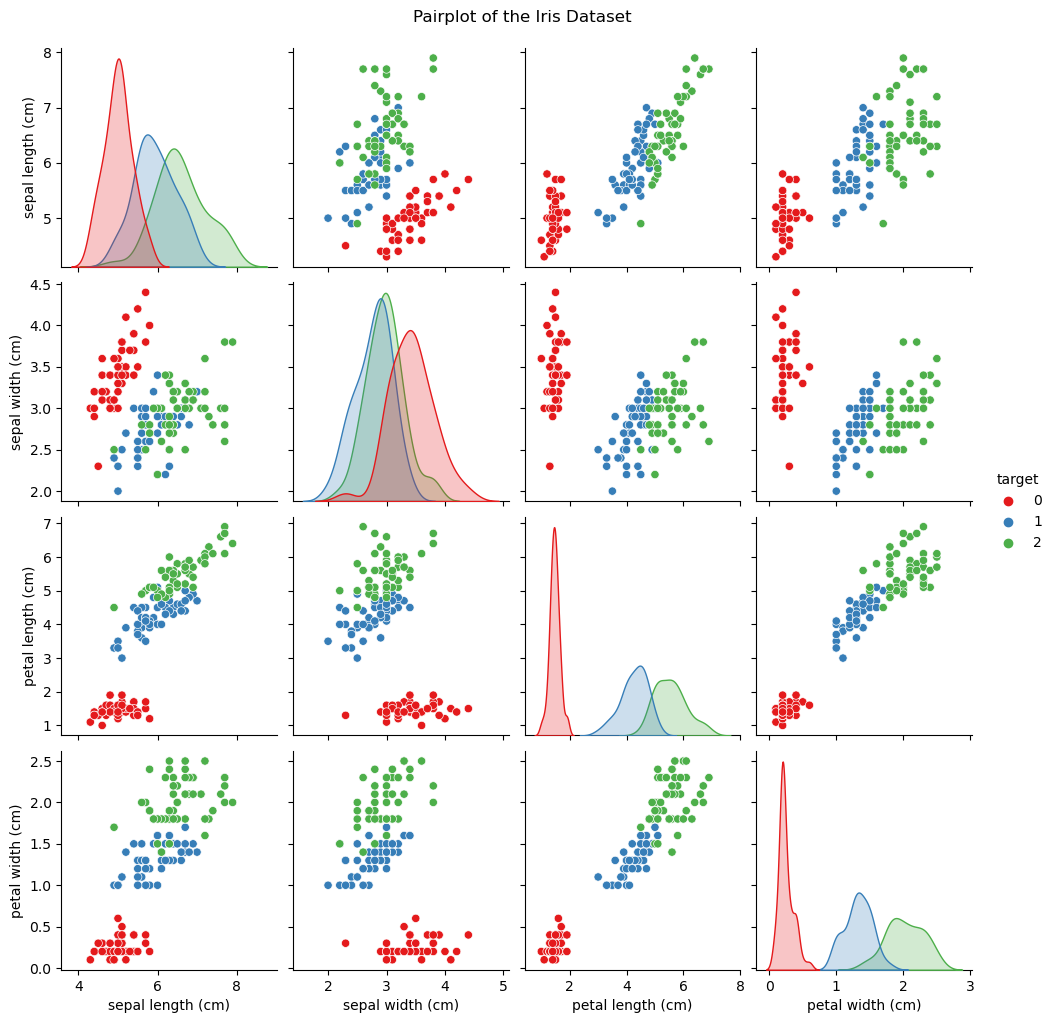

In [3]:
iris = load_iris()
sepal_cols = ["sepal length (cm)", "sepal width (cm)"]
petal_cols = ["petal length (cm)", "petal width (cm)"]

#DataFrame for better inspection
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

print("Basic Information about the Iris Dataset:")
print(iris_df.info())

print("\nFirst 5 Rows of the Dataset:")
print(iris_df.head())

print("\nBasic Statistics of the Dataset:")
print(iris_df.describe())

print("\nDistribution of Target Classes:")
print(iris_df['target'].value_counts())

sns.pairplot(iris_df, hue='target', palette='Set1')
plt.suptitle("Pairplot of the Iris Dataset", y=1.02)
plt.show()



#### Plot description

- Feature Comparisons: Each scatter plot shows the relationship between two features. For example, you might see sepal length vs sepal width, petal length vs petal width, etc.
- Colored by Target: Different colors represent different species: Setosa in Red, Versicolor in Blue and Virginica in Green.
- Diagonal plots: The diagonal plots show the distribution of each feature (histogram). For continuous features, kernel density estimation (KDE) plots might be used instead of histograms.

#### What to Look For in the Plot

- Feature Relationships: How the features relate to each other across different species.
- Class Separation: How well the different classes are separated based on the feature pairs. Clear separation indicates that the features are good discriminators for the species.
- Feature Distribution: Diagonal plots show how each feature is distributed across all samples. Features that show overlapping distributions might be less effective for classification.

## Making imbalance dataset

In [4]:
X, y = make_imbalance(
    iris.data,
    iris.target,
    sampling_strategy={0: 25, 1: 50, 2: 50},
    random_state=RANDOM_STATE,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({2: 37, 1: 36, 0: 20})
Testing target statistics: Counter({1: 14, 2: 13, 0: 5})


## Making the pipeline

NearMiss is an undersampling method that reduces the number of instances of the majority class in a dataset to balance the class distribution. It selectively removes examples from the majority class based on their proximity to the minority class examples.

NearMiss has different versions, each with a slightly different approach to selecting which majority class instances to remove:

### NearMiss Version 1

- Description: Retains majority class instances that are closest to the minority class instances.
- How It Works: Finds the k nearest neighbors for each minority class instance and keeps majority class instances that have the smallest average distance to these k neighbors.
- Purpose: Ensures that the majority class instances that are most relevant to the decision boundary are kept.

### NearMiss Version 2

- Description: Focuses on majority class instances that are farthest from the minority class instances.
- How It Works: For each majority class instance, it retains instances whose average distance to the k nearest minority class neighbors is the largest.
- Purpose: Reduces the influence of majority class instances that are less relevant to the minority class.

### NearMiss Version 3

- Description: A combination of the first two versions.
- How It Works: Balances between NearMiss Version 1 and Version 2 by considering both the proximity to and the distance from the minority class instances.
- Purpose: Aims to achieve a better trade-off between retaining useful majority class instances and discarding less relevant ones.



For this purpose, we use a pipeline that applies the NearMiss (version 2) undersampling technique to balance the dataset, standardizes the features using StandardScaler, and then trains a Logistic Regression model for classification.




In [5]:
# Print class distribution in the training set before NearMiss
print(f"Training target statistics before NearMiss: {Counter(y_train)}")

# Apply NearMiss (version=2) to the training set
nearmiss = NearMiss(version=2)  
X_train_nearmiss, y_train_nearmiss = nearmiss.fit_resample(X_train, y_train)

# Print class distribution in the training set after NearMiss
print(f"Training target statistics after NearMiss: {Counter(y_train_nearmiss)}")

# Print class distribution in the testing set (unchanged)
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics before NearMiss: Counter({2: 37, 1: 36, 0: 20})
Training target statistics after NearMiss: Counter({0: 20, 1: 20, 2: 20})
Testing target statistics: Counter({1: 14, 2: 13, 0: 5})


In [12]:
pipeline = make_pipeline(NearMiss(version=2), StandardScaler(), LogisticRegression())
pipeline.fit(X_train, y_train)

Pipeline(steps=[('nearmiss', NearMiss(version=2)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## VERY IMPORTANT!

Maintaining the integrity of the test dataset is crucial in machine learning to ensure a true evaluation of model performance. The primary purpose of the test dataset is to provide an unbiased assessment of how well the model generalizes to new, unseen data. Modifying the test set during training can lead to overfitting, where the model performs well on the modified test set but poorly on genuinely unseen data. Keeping the test set unchanged ensures that it accurately represents future data, validating the model's robustness and performance in real-world scenarios. Additionally, an unchanged test dataset serves as a standard benchmark, enabling fair comparisons between different models or approaches. This practice also maintains the integrity of the experimental setup, avoiding data leakage where information from the test set influences the model, thus undermining the validity of the evaluation. Adhering to this best practice ensures reliable, reproducible, and trustworthy machine learning models, aligning with the widely accepted methodology in the field.








## Showing results

Finally, we build a classification report based on metrics used with imbalanced dataset.

This report compiles the state-of-the-art metrics: precision/recall/specificity, f1 score, geometric mean, and index balanced accuracy of the geometric mean.

### Metrics definition

#### Precision ('pre')
Precision measures how many of the **positive predictions made by the model** were actually correct. A higher precision indicates fewer false positives.

                Precision = TP/TP+FP
- TP (True Positives): Correctly predicted positive cases.
- FP (False Positives): Incorrectly predicted as positive.

#### Recall ('rec')
Recall measures how many of the **actual positive cases were identified** by the model. A higher recall means fewer missed positive cases.

                Recall = TP/TP+FN

- FN (False Negatives): Incorrectly predicted as negative.

####  Specificity ('spe')
Specificity measures how many of the **actual negative cases were identified** correctly by the model. It is particularly useful for evaluating the performance in detecting negative cases.

                Specifity = TN/TN+FP

![metrics](./img/metrics.png)

####  F1 Score ('f1')
The F1 score balances precision and recall into a single metric. It’s particularly useful when the class distribution is imbalanced and you want to evaluate the model’s performance on the minority class.

F1=2* (Precision*Recall)/(Precision+Recall)

#### Geometric Mean ('geo')
The geometric mean provides a balance between recall and specificity, especially useful in imbalanced datasets where one class may be more prevalent.

Geo = (Recall * Specificity)**1/2


#### Index of Balanced Accuracy ('iba')
​This metric averages recall and specificity to provide a balanced measure of the model’s performance.

IBA = 0.5 * (Recall+Specificity)

#### Support ('sup')
Support is the number of occurrences of each class in the dataset. It provides context for other metrics by showing how many instances of each class are present.




In [26]:
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00         5
          1       1.00      0.64      1.00      0.78      0.80      0.62        14
          2       0.72      1.00      0.74      0.84      0.86      0.76        13

avg / total       0.89      0.84      0.89      0.84      0.86      0.73        32

